# Forecasters Toolbox

In [1]:
import sys
from utils import *

In [2]:
import warnings
warnings.simplefilter('ignore')

### Plot the data (visualize)

In [3]:
global_economy = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\global_economy.csv')
.pipe(compute, lambda x: dict(date = pd.to_datetime(x.Year, format='%Y'), GDP = x.GDP / 1e12))
.set_index('date'))
global_economy

,Country,Code,Year,Growth,CPI,Imports,Exports,Population,GDP
date,,,,,,,,,
1960-01-01,Afghanistan,AFG,1960,NaN,NaN,7.024793,4.132233,8996351.0,0.000538
1961-01-01,Afghanistan,AFG,1961,NaN,NaN,8.097166,4.453443,9166764.0,0.000549
1962-01-01,Afghanistan,AFG,1962,NaN,NaN,9.349593,4.878051,9345868.0,0.000547
1963-01-01,Afghanistan,AFG,1963,NaN,NaN,16.863910,9.171601,9533954.0,0.000751
1964-01-01,Afghanistan,AFG,1964,NaN,NaN,18.055555,8.888893,9731361.0,0.000800
...,...,...,...,...,...,...,...,...,...
2013-01-01,Zimbabwe,ZWE,2013,1.989493,109.079488,36.668735,21.987759,15054506.0,0.019091
2014-01-01,Zimbabwe,ZWE,2014,2.376929,108.847215,33.741470,20.930146,15411675.0,0.019496
2015-01-01,Zimbabwe,ZWE,2015,1.779873,106.224541,37.588635,19.160176,15777451.0,0.019963


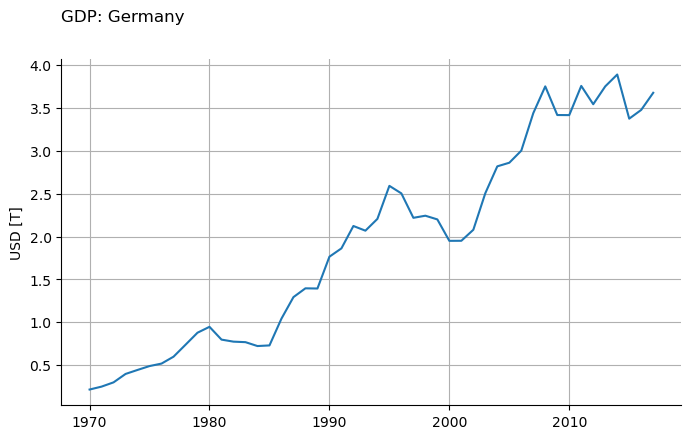

In [4]:
d = sweden_economy = global_economy.query("Country == 'Germany'").copy()
fig, ax = plt.subplots()
ax.plot(d.GDP)
ax.set(ylabel='USD [T]')
suptitle('GDP: Germany')
plt.grid()

### Define a model (specify)

In [5]:
smf.ols('GDP ~ Year', sweden_economy)

### Train the model (estimate)

In [6]:
models = (global_economy[~global_economy.GDP.isna()]
.groupby('Country')
.pipe(summarize, lambda x: dict(trend_model = smf.ols('GDP ~ Year', x).fit())))

In [7]:
#fig, ax = plt.subplots(3, 2)
#for country in ('Germany', 'Poland', 'France', 'United Kingdom', 'United States', 'China'):
    #economy = global_economy[global_economy.Country.eq(country)]
    #ax.plot(economy.GDP)
    #m = models.trend_model[country]
    #pred = m.get_prediction(economy).summary_frame()
    #ax.plot(economy.index, pred['mean'])
    #ax.grid()

### Check model performance (evaluate)

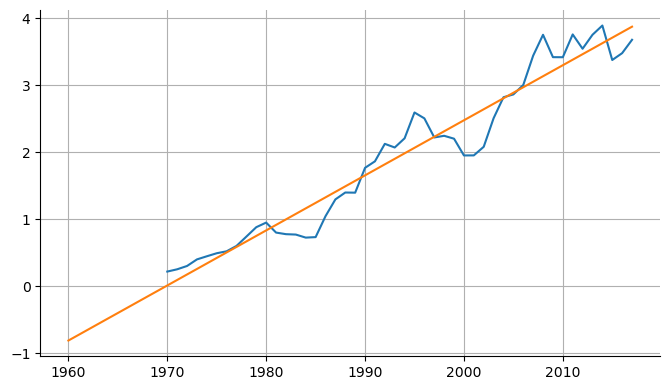

In [8]:
fig, ax = plt.subplots()
country = 'Germany'
economy = global_economy[global_economy.Country.eq(country)]
ax.plot(economy.GDP)
m = models.trend_model[country]
pred = m.get_prediction(economy).summary_frame()
ax.plot(economy.index, pred['mean'])
ax.grid()

### Produce forecasts

In [9]:
global_economy.Year.max()

2017

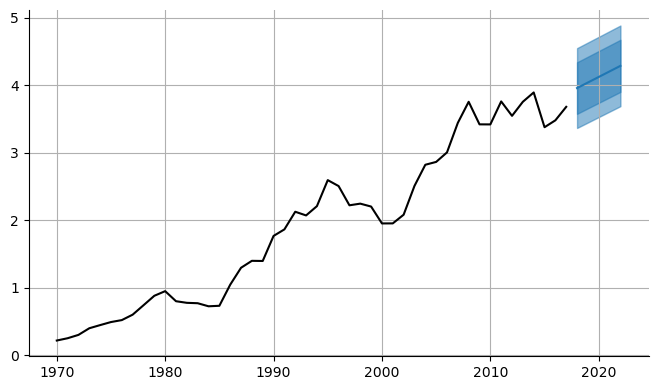

In [10]:
fig, ax = plt.subplots()
country = 'Germany'
economy = global_economy[global_economy.Country.eq(country)]
ax.plot(economy.Year, economy.GDP, color='k')
m = models.trend_model[country]
x = pd.DataFrame(dict(Year=np.arange(2018, 2023)))
pred95 = m.get_prediction(x).summary_frame()
pred80 = m.get_prediction(x).summary_frame(alpha=.2)
ax.plot(x.Year, pred80['mean'])
ax.fill_between(x.Year, pred95.obs_ci_lower, pred95.obs_ci_upper, color='C0', alpha=.5)
ax.fill_between(x.Year, pred80.obs_ci_lower, pred80.obs_ci_upper, color='C0', alpha=.5)
plt.grid()

## Simple forecasting methods

### SimpleTS

In [11]:
class SimpleTSModel:
    '''Simple TS model base class'''
    def __init__(self, y):
        '''y data and sampling frequency'''
        if not hasattr(y, 'index'):
            y = pd.Series(y)
        if hasattr(y.index, 'inferred_freq'):
            self.y = y.asfreq(y.index.inferred_freq)
            self.freq = self.y.index.freq
        else:
            self.y = y.copy()
            self.freq = None

    def fit(self):
        '''nothing to do here'''
        return self

    def forecast(self, dt=None, end=None, periods=None):
        '''Forward looking prediction'''
        assert sum([dt is None, end is None, periods is None]) == 2
        tmax = self.y.index.max()
        if dt is not None:
            end = tmax + (pd.to_timedelta(dt) if self.freq else dt)
        elif end is not None:
            end = pd.to_datetime(end) if self.freq else end
        elif periods is not None:
            end = tmax + periods * (self.freq or 1)
        return self.predict(tmax + 1 * (self.freq or 1), end)

    def _normalize_times(self, start, end):
        '''Do some tedious datetime manipulation'''
        Y = self.y
        t0 = Y.index.min()
        if start is None:
            start = t0
        if end is None:
            end = Y.index.max()
        if self.freq is not None:
            start = pd.to_datetime(start)
            end = pd.to_datetime(end)
        if self.freq:
            index = pd.date_range(t0, end, freq=self.freq)
        else:
            index = np.arange(t0, end+1)
        return start, end, index

class TSMean(SimpleTSModel):
    '''The future will be the average of the past'''
    def predict(self, start=None, end=None):
        # value is always the mean
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        m = Y.mean()
        out = pd.Series(m, index=index)
        out = out.loc[start:].copy()
        return out

class TSNaive(SimpleTSModel):
    '''The future looks like today'''
    def predict(self, start=None, end=None):
        # tomorrow probably same as today
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(1)
        out.loc[Y.index.max():] = Y.iloc[-1]
        out = out.loc[start:].copy()
        return out.copy()

class TSNaiveSeasonal(SimpleTSModel):
    '''Next year will fluctuate the same as this year'''
    def __init__(self, y, lag):
        super(TSNaiveSeasonal, self).__init__(y)
        self.lag = lag
        assert self.y.index.min() + lag * (self.freq or 1) < self.y.index.max(), \
        'lag less than input ts'

    def predict(self, start=None, end=None):
        # tomorrow probably same as last time
        Y, lag = self.y, self.lag
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(lag)
        i = 0
        while np.isnan(out.iloc[-1]):
            mask = out.isna()
            out[mask] = out.shift(lag)[mask]
            i +=1
        out = out.loc[start:].copy()
        return out.copy()

class TSDrift(SimpleTSModel):
    '''Draw a line from start to end and extrapolate'''
    def predict(self, start=None, end=None):
        Y = self.y
        Y0 = Y.values[0]
        YT = Y.shift(-1)
        start, end, index = self._normalize_times(start, end)
        YT = pd.Series(np.nan, index=index)
        YT.loc[Y.index.min():Y.index.max()] = Y
        YT = YT.shift(1)
        YT.iloc[0] = Y.iloc[0]
        h = pd.Series(1, index=index)
        extrap_mask = YT.isna()
        h.loc[YT.isna()] = np.arange(1, extrap_mask.sum()+1)
        YT.loc[extrap_mask] = Y.iloc[-1]
        x = np.maximum(1, np.arange(len(YT)) - 1)
        out = YT + h * ((YT - Y0) / x)
        out.iloc[0] = np.nan
        out = out.loc[start:].copy()
        return out.copy()

### Example: Australian quarterly brick production

In [12]:
d = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\aus_production.csv')
aus_production = (d
                  .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
                  .set_index('Date'))

In [13]:
bricks = aus_production['1971-01-01':'2004-01-01']

In [14]:
m = TSMean(bricks.Bricks)
n = TSNaive(bricks.Bricks).fit()
s = TSNaiveSeasonal(bricks.Bricks, 4)
dr = TSDrift(bricks.Bricks)

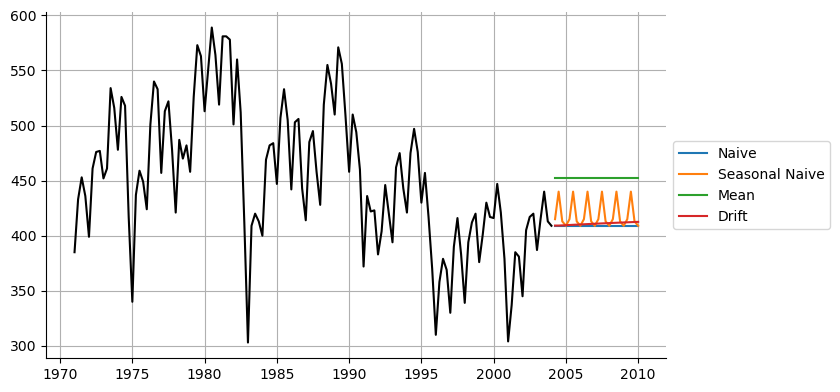

In [15]:
fig, ax = plt.subplots()
ax.plot(bricks.Bricks, color='k')
ax.plot(n.forecast(end='2010'), color='C0', label='Naive')
ax.plot(s.forecast(end='2010'), color='C1', label='Seasonal Naive')
ax.plot(m.forecast(end='2010'), color='C2', label='Mean')
ax.plot(dr.forecast(end='2010'), color='C3', label='Drift')
ax.legend(**legend_right)
ax.grid()

### Example: Australian quarterly beer production

In [16]:
Y = aus_production.Beer
Ytrain = Y[:'2006']
m = TSMean(Ytrain)
n = TSNaive(Ytrain).fit()
s = TSNaiveSeasonal(Ytrain, 4)
dr = TSDrift(Ytrain)

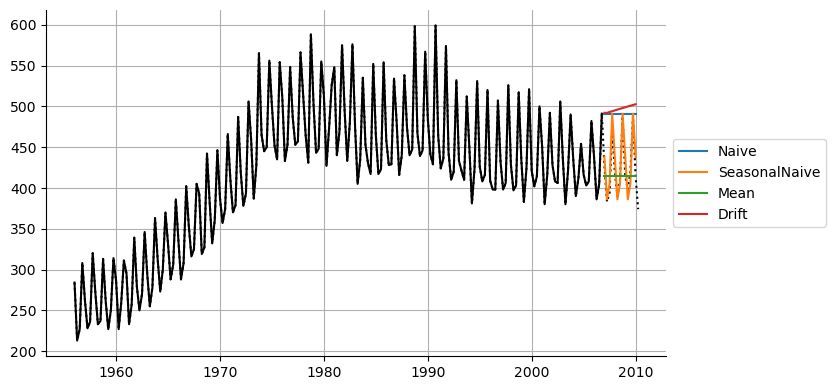

In [17]:
fig, ax = plt.subplots()
ax.plot(Ytrain, 'k')
ax.plot(Y, 'k:')
ax.plot(n.forecast(end='2010'), color='C0', label='Naive')
ax.plot(s.forecast(end='2010'), color='C1', label='SeasonalNaive')
ax.plot(m.forecast(end='2010'), color='C2', label='Mean')
ax.plot(dr.forecast(end='2010'), color='C3', label='Drift')
ax.legend(**legend_right)
ax.grid()

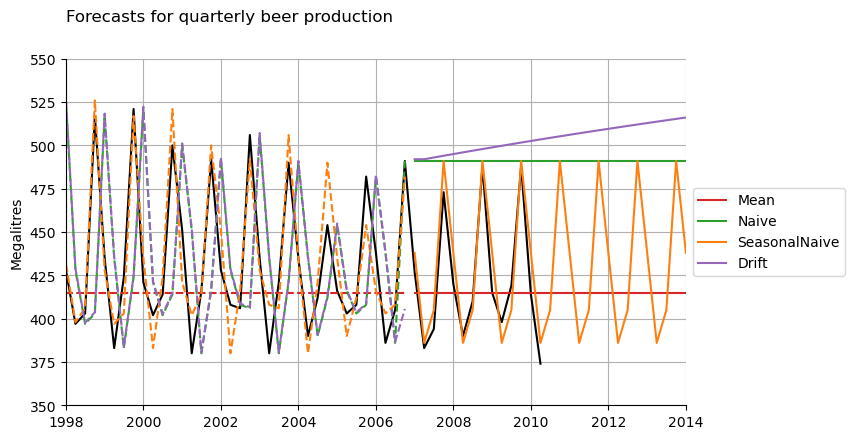

In [18]:
fig, ax = plt.subplots()
ax.plot(Y, color='k')
c = 'C3 C2 C1 C4'.split()
ax.plot(m.predict(), ls='--', color=c[0])
ax.plot(n.predict(), ls='--', color=c[1])
ax.plot(s.predict(), ls='--', color=c[2])
ax.plot(dr.predict(), ls='--', color=c[3])
end = pd.to_datetime('2014')
ax.plot(m.forecast(end=end), color=c[0], label='Mean')
ax.plot(n.forecast(end=end), color=c[1], label='Naive')
ax.plot(s.forecast(end=end), color=c[2], label='SeasonalNaive')
ax.plot(dr.forecast(end=end), color=c[3], label='Drift')
ax.set(ylabel='Megalitres', ylim=(350, 550), xlim=(pd.to_datetime('1998'), end))
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Forecasts for quarterly beer production')
ax.grid()

In [19]:
RMSRE = lambda Y, y: RMSE(1, y/Y)

In [20]:
for model in (m, n, s, dr):
    e = RMSRE(Y['2006'], model.predict('2006', Y.index.max()))
    print(f'{model.__class__.__name__:>20}: {e}')

              TSMean: 0.09079349315684158
             TSNaive: 0.08723610909521809
     TSNaiveSeasonal: 0.03483313403592543
             TSDrift: 0.12407676374205893


### Example: Apple’s daily closing stock price

In [21]:
APPL = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\gafa_stock.csv')
.query("Symbol == 'AAPL'")
.sort_values('Date')
.reset_index(drop=True)
.pipe(compute, lambda x: dict(Date = pd.to_datetime(x.Date, format='%Y-%m-%d'))))

In [22]:
APPL_2015 = APPL.query('Date.dt.year == 2015')
APPL_2015

,Symbol,Open,High,Low,Close,Adj_Close,Volume,Date
252,AAPL,111.389999,111.440002,107.349998,109.330002,101.528191,53204600,2015-01-02
253,AAPL,108.290001,108.650002,105.410004,106.250000,98.667984,64285500,2015-01-05
254,AAPL,106.540001,107.430000,104.629997,106.260002,98.677261,65797100,2015-01-06
255,AAPL,107.199997,108.199997,106.699997,107.750000,100.060936,40105900,2015-01-07
256,AAPL,109.230003,112.150002,108.699997,111.889999,103.905510,59364500,2015-01-08
...,...,...,...,...,...,...,...,...
499,AAPL,109.000000,109.000000,107.949997,108.029999,102.030258,13570400,2015-12-24
500,AAPL,107.589996,107.690002,106.180000,106.820000,100.887466,26704200,2015-12-28
501,AAPL,106.959999,109.430000,106.860001,108.739998,102.700844,30931200,2015-12-29
502,AAPL,108.580002,108.699997,107.180000,107.320000,101.359718,25213800,2015-12-30


In [23]:
len(APPL_2015)

252

In [24]:
Y = APPL.Close
Ytrain = APPL_2015.Close
nsamples = len(APPL_2015)
m = TSMean(Ytrain)
n = TSNaive(Ytrain).fit()
s = TSNaiveSeasonal(Ytrain, nsamples - 2)
dr = TSDrift(Ytrain)

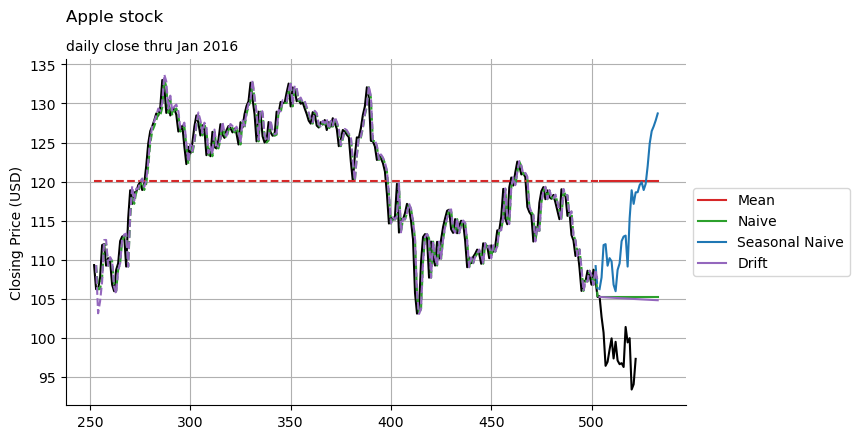

In [25]:
fig, ax = plt.subplots()
ax.plot(Y[APPL.Date.between('2015-01-01', '2016-01-30')], color='k')
c = 'C3 C2 C0 C4'.split()
ax.plot(m.predict(),  ls='--', color=c[0])
ax.plot(n.predict(),  ls='--', color=c[1])
ax.plot(s.predict(),  ls='--', color=c[2])
ax.plot(dr.predict(), ls='--', color=c[3])
ax.plot(m.forecast(30),  color=c[0], label='Mean')
ax.plot(n.forecast(30),  color=c[1], label='Naive')
ax.plot(s.forecast(30),  color=c[2], label='Seasonal Naive')
ax.plot(dr.forecast(30), color=c[3], label='Drift')
ax.set(ylabel='Closing Price (USD)')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Apple stock')
ax.set(title='daily close thru Jan 2016')
ax.grid()

## Fitted values and residuals

### Residuals

In [26]:
results = APPL_2015.assign(
    mean = m.predict(),
    naive = n.predict(),
    naive_seasonal = s.predict(),
    drift = dr.predict(),
    resid_mean = m.predict() - Ytrain,
    resid_naive = n.predict() - Ytrain,
    resid_naive_seasonal = s.predict() - Ytrain,
    resid_drift = dr.predict() - Ytrain,)
results.head()

,Symbol,Open,High,Low,Close,Adj_Close,Volume,Date,mean,naive,naive_seasonal,drift,resid_mean,resid_naive,resid_naive_seasonal,resid_drift
252,AAPL,111.389999,111.440002,107.349998,109.330002,101.528191,53204600,2015-01-02,120.04,NaN,NaN,NaN,10.709998,NaN,NaN,NaN
253,AAPL,108.290001,108.650002,105.410004,106.250000,98.667984,64285500,2015-01-05,120.04,109.330002,NaN,109.330002,13.790000,3.080002,NaN,3.080002
254,AAPL,106.540001,107.430000,104.629997,106.260002,98.677261,65797100,2015-01-06,120.04,106.250000,NaN,103.169998,13.779998,-0.010002,NaN,-3.090004
255,AAPL,107.199997,108.199997,106.699997,107.750000,100.060936,40105900,2015-01-07,120.04,106.260002,NaN,104.725002,12.290000,-1.489998,NaN,-3.024998
256,AAPL,109.230003,112.150002,108.699997,111.889999,103.905510,59364500,2015-01-08,120.04,107.750000,NaN,107.223333,8.150001,-4.139999,NaN,-4.666666


### Residual diagnostics

### Example: Forecasting Apple daily closing stock price

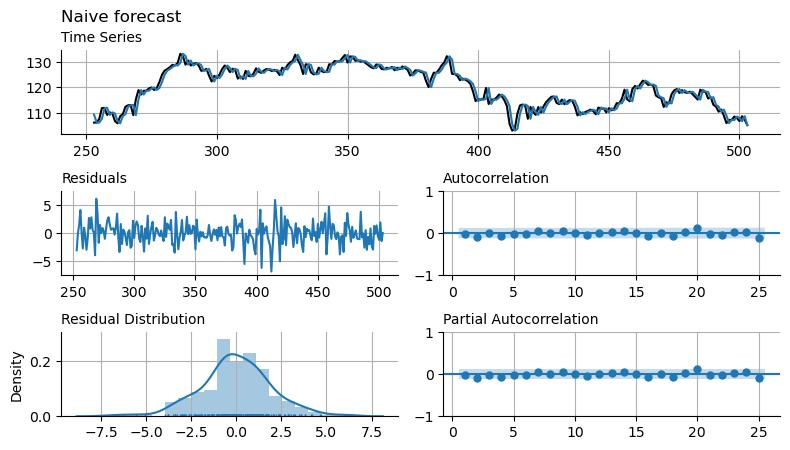

In [27]:
plot_tsresiduals(Ytrain, results.naive)
suptitle('Naive forecast')
plt.subplots_adjust(top=.9)

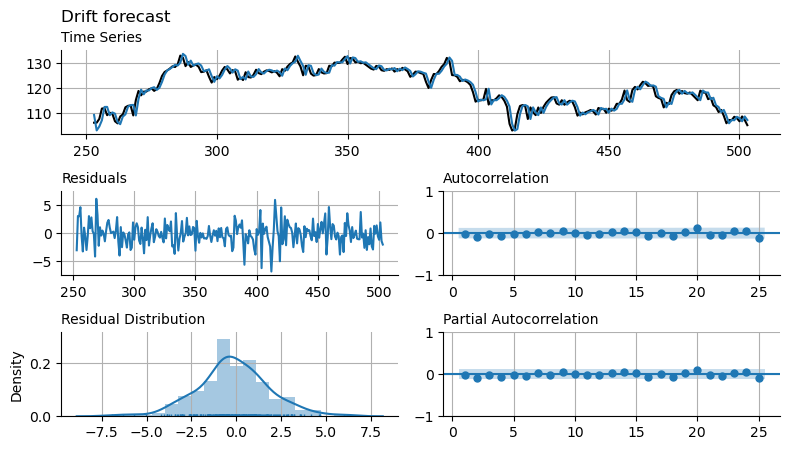

In [28]:
plot_tsresiduals(Ytrain, results.drift)
suptitle('Drift forecast')
plt.subplots_adjust(top=.9)

### Portmanteau tests for autocorrelation

### Naive

In [29]:
sm.stats.acorr_ljungbox(
    results.resid_naive.dropna(), lags=[10], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,4.252156,0.935256,4.150351,0.94031


### Drift

In [30]:
sm.stats.acorr_ljungbox(
    results.resid_drift.dropna(), model_df=1, lags=[10], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,4.906924,0.842345,4.786918,0.852473


### Distributional forecasts and prediction intervals

In [31]:
mult = pd.DataFrame(dict(Percentage=np.r_[50:90:5, 90:100]))

In [32]:
mult['Multiplier'] = stats.norm.isf((1 - mult.Percentage/100) / 2)
mult = mult.set_index('Percentage')

### One-step prediction intervals

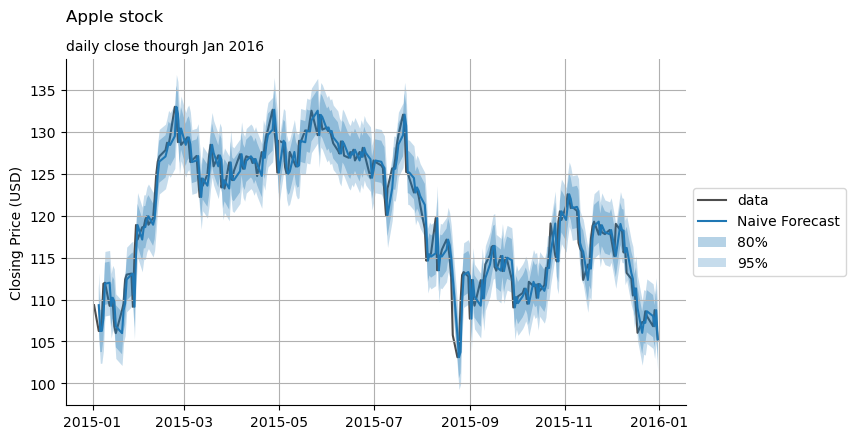

In [33]:
fig, ax = plt.subplots()
r = results.set_index('Date')
ax.plot(r.Close, color='.3', zorder=-10, label='data')
ax.plot(r.naive, lw=1.5, label='Naive Forecast')
sigma = results.resid_naive.std()
m80, m95 = mult.Multiplier.loc[[80, 95]]
ax.fill_between(r.index, r.naive - m80*sigma, r.naive + m80*sigma, alpha=.33, lw=0, label='80%')
ax.fill_between(r.index, r.naive - m95*sigma, r.naive + m95*sigma, alpha=.25, color='C0', lw=0, label='95%')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Apple stock')
ax.set(title='daily close thourgh Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

### Multi-step prediction intervals

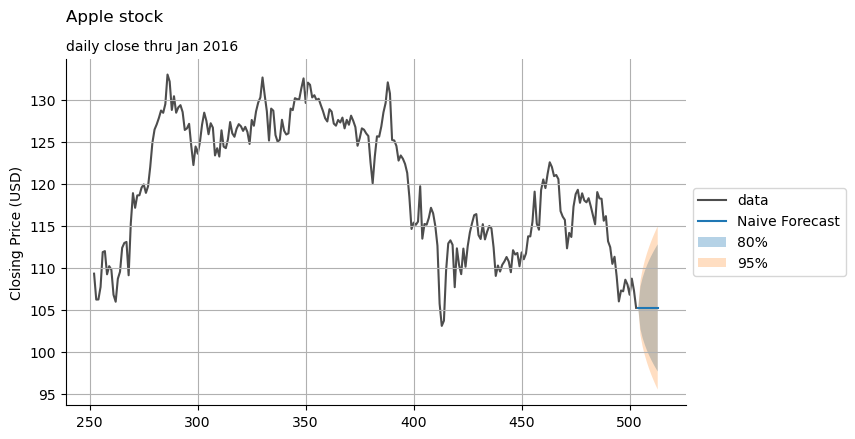

In [34]:
fig, ax = plt.subplots()
a = APPL[APPL.Date.lt('2016-02-01')]
ax.plot(APPL_2015.Close, color='.3', zorder=-10, label='data')
fc = n.forecast(10)
ax.plot(fc, lw=1.5, label='Naive Forecast')
sigma = results.resid_naive.std()
m80, m95 = mult.Multiplier.loc[[80, 90]]
didx = fc.index - fc.index.min()
ax.fill_between(fc.index, fc - m80*sigma*np.sqrt(didx), fc + m80*sigma*np.sqrt(didx), alpha=.33, lw=0, label='80%')
ax.fill_between(fc.index, fc - m95*sigma*np.sqrt(didx), fc + m95*sigma*np.sqrt(didx), alpha=.25, lw=0, label='95%')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Apple stock')
ax.set(title='daily close thru Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

### Prediction intervals from bootstrapped residulas

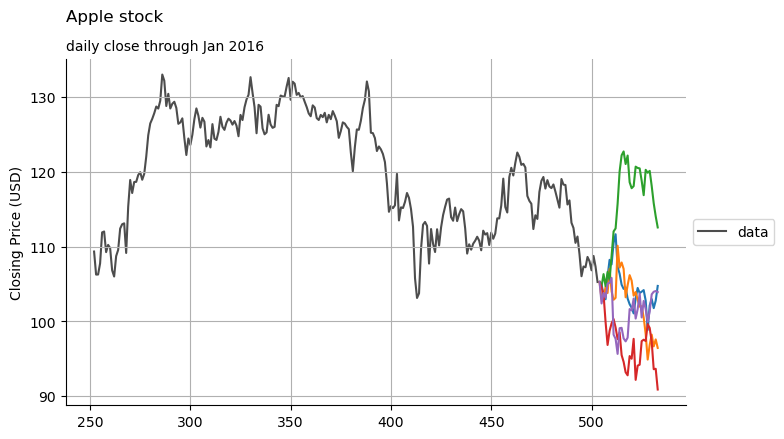

In [35]:
fig, ax = plt.subplots()
a = APPL[APPL.Date.lt('2016-02-01')]
ax.plot(APPL_2015.Close, color='.3', zorder=-10, label='data')
fc = n.forecast(30)
sigma = results.resid_naive.std()
for i in range(5):
    ax.plot(fc + np.r_[0, np.random.normal(0, sigma, len(fc) - 1).cumsum()])
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Apple stock')
ax.set(title='daily close through Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

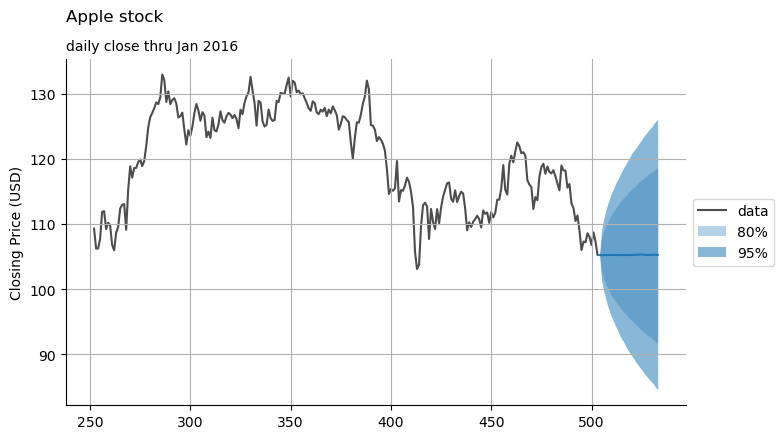

In [36]:
fig, ax = plt.subplots()
g = APPL[APPL.Date.lt('2016-02-01')]
ax.plot(APPL_2015.Close, color='.3', zorder=-10, label='data')
fc = n.forecast(30)
sigma = results.resid_naive.std()
errs = np.array([
    np.r_[0, np.random.normal(0, sigma, len(fc)-1).cumsum()]
    for i in range(50000) ])
lo, mid, hi = np.percentile(errs, [10, 50, 90], axis=0)
ax.plot(fc + mid)
ax.fill_between(fc.index, fc+lo, fc+hi, alpha=.33, color='C0', lw=0, label='80%')
lo, mid, hi = np.percentile(errs, [2.5, 50, 97.5], axis=0)
ax.fill_between(fc.index, fc+lo, fc+hi, alpha=.53, color='C0', lw=0, label='95%')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Apple stock')
ax.set(title='daily close thru Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

## Forecasting with decomposition

### Employment in the US retail sector

In [37]:
d = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\fpp3\us_employment.csv')
d = us_retail_employment = (
    d
    .assign(date=pd.to_datetime(d.Month, format='%Y %b'))
    .pipe(compute, lambda x: dict(year=x.date.dt.year))
    .query("year >= 1990 and Title == 'Retail Trade'")
    .set_index('date')
    .drop(columns='year Series_ID'.split())
) 
us_retail_employment

,Month,Title,Employed
date,,,
1990-01-01,1990 Jan,Retail Trade,13255.8
1990-02-01,1990 Feb,Retail Trade,12966.3
1990-03-01,1990 Mar,Retail Trade,12938.2
1990-04-01,1990 Apr,Retail Trade,13012.3
1990-05-01,1990 May,Retail Trade,13108.3
...,...,...,...
2019-05-01,2019 May,Retail Trade,15691.6
2019-06-01,2019 Jun,Retail Trade,15775.5
2019-07-01,2019 Jul,Retail Trade,15785.9


In [38]:
stl = sm.tsa.STL(d.Employed).fit()

In [39]:
s_stl = TSNaiveSeasonal(stl.seasonal, 12)

In [40]:
dr_stl = TSDrift(d.Employed - stl.seasonal)

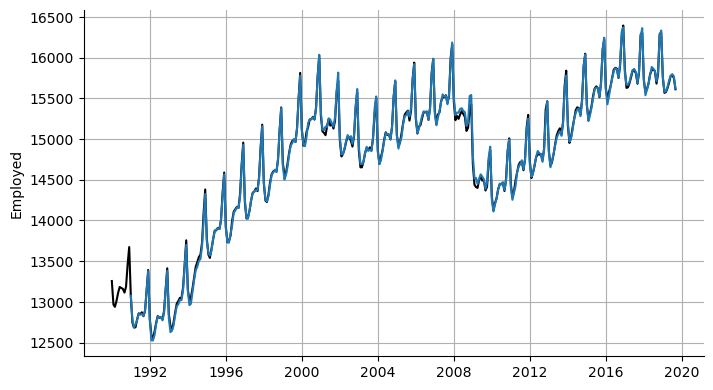

In [41]:
fig, ax = plt.subplots(figsize=sizets)
ax.plot(d.Employed, 'k')
ax.plot(s_stl.predict() + dr_stl.predict())
#ax.plot(s_stl.forecast('250') + dr_stl.forecast('250'))
ax.set(ylabel='Employed')
ax.grid()

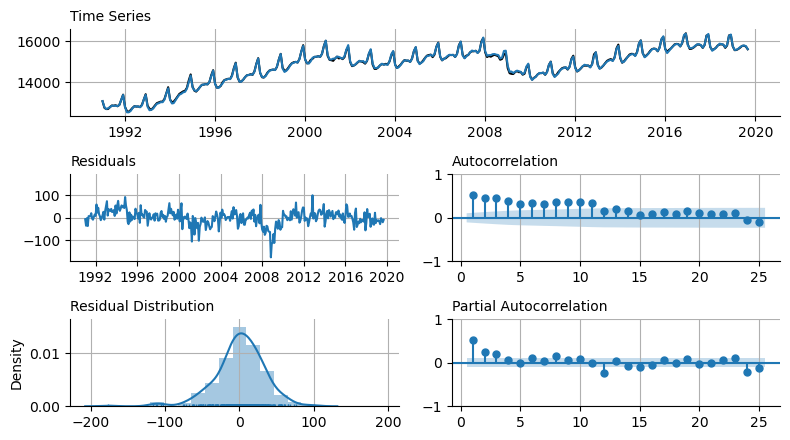

In [42]:
plot_tsresiduals(d.Employed, s_stl.predict() + dr_stl.predict());

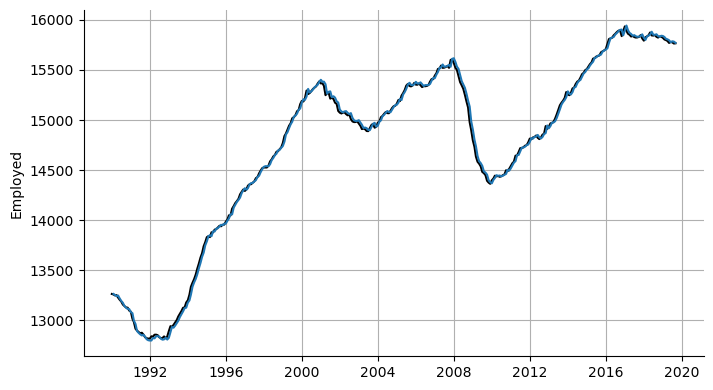

In [43]:
fig, ax = plt.subplots(figsize=sizets)
ax.plot(d.Employed - stl.seasonal, 'k')
ax.plot(dr_stl.predict())
#ax.plot(dr_stl.forecast('4y'))
ax.set(ylabel='Employed')
ax.grid()

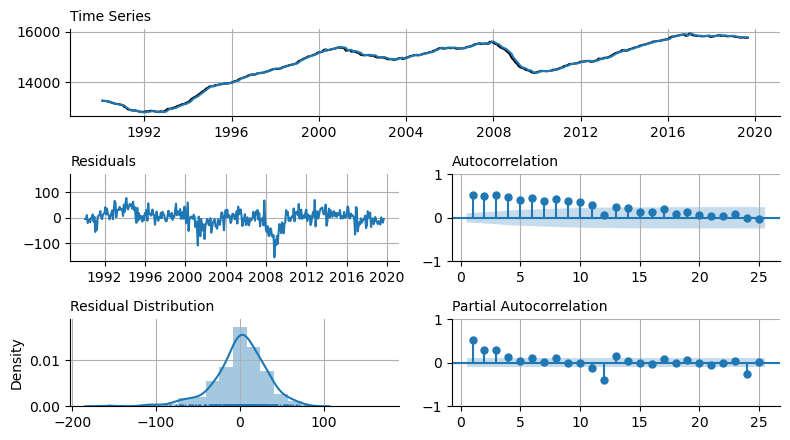

In [44]:
plot_tsresiduals(d.Employed - stl.seasonal, dr_stl.predict());

### Evaluating forecast accuracy

In [45]:
recent_production = aus_production['1992':]
split = '2007-12-01'
beer_train = recent_production[:split]
beer_test = recent_production[split:]

Ytrain = beer_train.Beer
ms = dict(
    Drift = TSDrift(Ytrain),
    Mean = TSMean(Ytrain),
    Naive = TSNaive(Ytrain),
    SeasonalNaive = TSNaiveSeasonal(Ytrain, 4),
)

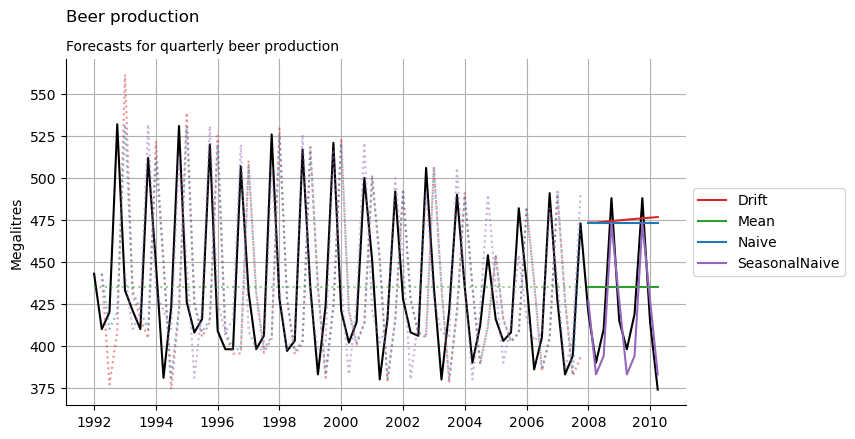

In [46]:
fig, ax = plt.subplots()
Y = recent_production.Beer
ax.plot(Y, color='k')
c = 'C3 C2 C0 C4'.split()
for ((label, model), c) in zip(ms.items(), c):
    ax.plot(model.predict(),  ls=':', color=c, alpha=.5)
    ax.plot(model.forecast(end=Y.index.max()),  color=c, label=label)
ax.set(ylabel='Megalitres')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Beer production')
ax.set(title='Forecasts for quarterly beer production')
ax.grid()

In [47]:
tsaccuracy(beer_test.Beer, ms)

,RMSE,MAE,MAPE,MASE
Drift,64.367670,58.524029,14.483635,NaN
Mean,38.447245,34.825000,8.283390,NaN
Naive,62.692902,57.400000,14.184424,NaN
SeasonalNaive,14.310835,13.400000,3.168503,NaN


In [48]:
GOOG = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\gafa_stock.csv')
.query("Symbol == 'GOOG'")
.sort_values('Date')
.reset_index(drop=True)
.pipe(compute, lambda x: dict(Date = pd.to_datetime(x.Date, format='%Y-%m-%d'))))

In [49]:
GOOG_2015 = GOOG.query('Date.dt.year == 2015')

In [50]:
t1, t2, t3 = pd.to_datetime('2015-01-01 2016-01-01 2016-02-01'.split())
goog_train, goog_test = GOOG[GOOG.Date.between(t1, t2)], GOOG[GOOG.Date.between(t2+pd.to_timedelta('1d'), t3)]

Ytrain = goog_train.Close
ms = dict(
    Drift = TSDrift(Ytrain),
    Mean = TSMean(Ytrain),
    Naive = TSNaive(Ytrain),
)

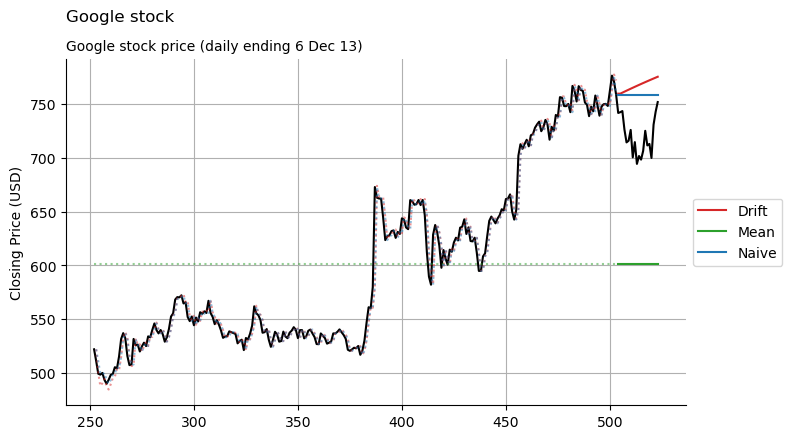

In [51]:
fig, ax = plt.subplots()
#ax.plot(goog_train.Close, color='k')
#ax.plot(goog_test.Close, color='k')
ax.plot(pd.concat((goog_train.Close, goog_test.Close)), 'k')
c = 'C3 C2 C0 C4'.split()
for ((label, model), c) in zip(ms.items(), c):
    ax.plot(model.predict(),  ls=':', color=c, alpha=.5)
    ax.plot(model.forecast(end=goog_test.index.max()),  color=c, label=label)
ax.set(ylabel='Closing Price (USD)')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='Google stock price (daily ending 6 Dec 13)')
ax.grid()

In [52]:
tsaccuracy(goog_test.Close, ms)

,RMSE,MAE,MAPE,MASE
Drift,50.747689,47.285130,6.628159,NaN
Mean,119.861478,118.620455,16.423740,NaN
Naive,42.359750,38.709003,5.434785,NaN


### Time series cross-validation

In [53]:
goog_train_cv = pd.concat([GOOG_2015[:n].assign(id=n) for n in range(3, len(GOOG_2015))])

In [54]:
Y, y = np.transpose([
    (GOOG.Close.loc[d.index.max()+1], TSDrift(d.Close).forecast(1).values[0]) 
    for (i, d) in goog_train_cv.groupby('id')])
RMSE(Y, y), MAE(Y, y), MAPE(Y, y)

(11.26819060357925, 7.261240194403708, 1.194023505537906)

In [55]:
Y = goog_train.Close
y = TSDrift(goog_train.Close).predict()
RMSE(Y, y), MAE(Y, y), MAPE(Y, y)

(11.244363890080823, 7.250572216759056, 1.193761110121608)

### Forecast horizon accuracy with cross-validation

In [56]:
horizons = np.arange(1, 9)
rmses = np.array([np.mean([RMSE(GOOG.Close.loc[d.index.max()+horizon], TSDrift(d.Close).forecast(dt=horizon).values[0]) 
                   for (i, d) in goog_train_cv.groupby('id')]) 
          for horizon in horizons])

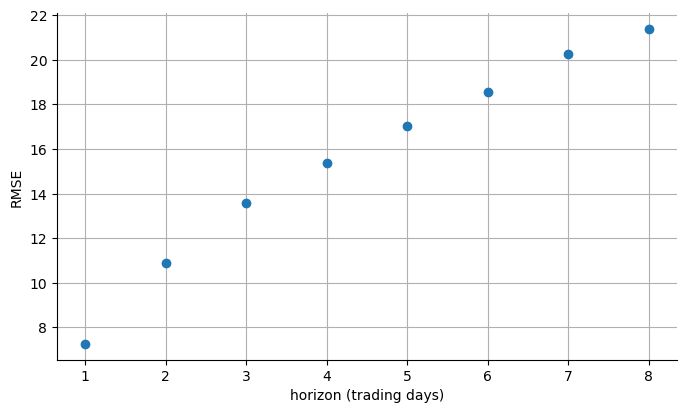

In [57]:
fig, ax = plt.subplots()
ax.plot(horizons, rmses, 'o')
ax.set(xlabel='horizon (trading days)', ylabel='RMSE')
ax.grid()

In [58]:
naive_rmses = np.array([
    np.mean([
        RMSE(GOOG.Close.loc[d.index.max()+horizon], TSNaive(d.Close).forecast(dt=horizon).values[0])
        for (i, d) in goog_train_cv.groupby('id') ])
    for horizon in horizons
])

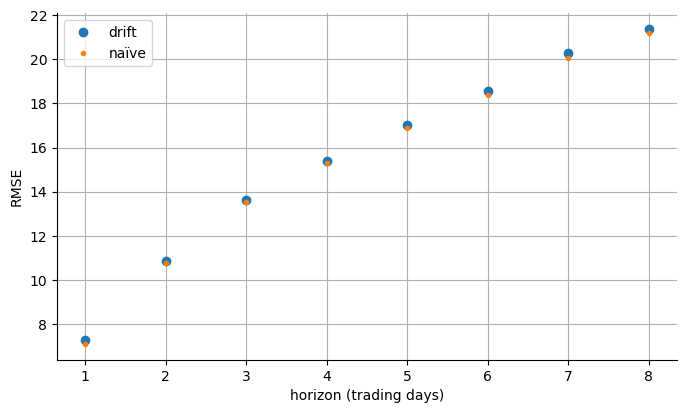

In [59]:
fig, ax = plt.subplots()
ax.plot(horizons, rmses, 'o', label='drift')
ax.plot(horizons, naive_rmses, '.', label='naïve')
ax.set(xlabel='horizon (trading days)', ylabel='RMSE')
ax.legend()
ax.grid()